copy of 26_

# Interpolate with downstream distance instead of x

This allows better interpolation all the way to line0 though does something a wee funny in last section, where edges of channel overlap inside


In [1]:
import matplotlib.pyplot as plt
import numpy as np
import glob
import os
import sys
import time
import datetime as dt
import pandas as pd
import geopandas as gpd
import scipy as sp
from scipy import signal
from tqdm.notebook import tqdm

from shapely.geometry import Point, LineString, Polygon, MultiPoint
import fiona
from shapely.ops import nearest_points

In [2]:
new_gpr = gpd.read_file('/Volumes/arc_04/FIELD_DATA/K8621920/RES/PROCESSED_LINES/picked_bed.shp')
old_gpr = gpd.read_file('/Volumes/arc_04/FIELD_DATA/K8621920/RES/PROCESSED_LINES/1516_gprlines.shp')
old_gpr['camp'] = 'KIS2' 

In [3]:
print(new_gpr.keys(),old_gpr.keys())

Index(['CDP', 'x', 'y', 'DELAY', 'line_name', 'surf', 'Unnamed_ 1', 'SEQnum',
       'camp', 'time_UTC', 'ice_thickn', 'bed', 'geometry'],
      dtype='object') Index(['x', 'y', 'surf', 'bed', 'ice_thickn', 'line_name', 'geometry', 'camp'], dtype='object')


In [4]:
old_gpr.line_name.unique()

array(['lineolddiagonalcross567', 'lineoldAPREScross', 'leftold4p55p5',
       'lineold5p5', 'rightold4p55p5', 'lineold4'], dtype=object)

In [5]:
bed_gdf = pd.concat([new_gpr,old_gpr])

In [6]:
def add_distance_to_gdf(gdf):
    """
    Input: geodataframe
    Output: Adds columns 'dx' and 'distance_cum' to the geodataframe
    """
    tmp_dfp = [Point.distance(gdf.geometry.iloc[i]) for i,Point in enumerate(gdf.geometry.iloc[1:])] #note the 1:, equivalent to i+1
    tmp_dfp[:0] = [0]
    gdf['dx'] = pd.Series(tmp_dfp) 
    gdf['distan_cum'] = gdf.dx.cumsum().copy()
    
def add_dice_thickndx(gdf):
    """
    Input: geodataframe
    Output: Adds columns 'dice_thickn' and 'dice_thickndx' to the geodataframe
    """
    
    gdf['dice_thickn'] = gdf.ice_thickn.diff().copy()
        
    gdf['dice_thickndx'] = gdf.dice_thickn.to_numpy()/gdf.dx.to_numpy()

In [7]:
ll = {} #a dictionary of geodataframes of radarlines over KIS2, ie one gdf for each line.

for line in bed_gdf[bed_gdf.camp =='KIS2'].line_name.unique().tolist():
    ll[line] = bed_gdf[(bed_gdf.line_name==line) & (bed_gdf.camp=='KIS2')].copy()
    ll[line].sort_values(by='x',inplace=True)
    ll[line].reset_index(drop=True,inplace=True)
    add_distance_to_gdf(ll[line])
    add_dice_thickndx(ll[line])
    

/Users/home/whitefar/miniconda3/envs/remote_sensing/lib/python3.7/site-packages/ipykernel_launcher.py:19: RuntimeWarning: divide by zero encountered in true_divide
/Users/home/whitefar/miniconda3/envs/remote_sensing/lib/python3.7/site-packages/ipykernel_launcher.py:19: RuntimeWarning: invalid value encountered in true_divide
/Users/home/whitefar/miniconda3/envs/remote_sensing/lib/python3.7/site-packages/ipykernel_launcher.py:19: RuntimeWarning: invalid value encountered in true_divide
/Users/home/whitefar/miniconda3/envs/remote_sensing/lib/python3.7/site-packages/ipykernel_launcher.py:19: RuntimeWarning: invalid value encountered in true_divide
/Users/home/whitefar/miniconda3/envs/remote_sensing/lib/python3.7/site-packages/ipykernel_launcher.py:19: RuntimeWarning: invalid value encountered in true_divide
/Users/home/whitefar/miniconda3/envs/remote_sensing/lib/python3.7/site-packages/ipykernel_launcher.py:19: RuntimeWarning: divide by zero encountered in true_divide
/Users/home/whitefar

In [8]:
cross_channel_lines = ['line7p75','line7p5','line7p25','line7', 'line6','line5','lineAPREScross','line4','line3','line2','line1','line0']

#no line0 
# cross_channel_lines = [ 'line7p75','line7p5','line7p25','line7', 'lineolddiagonalcross567', 'lineoldAPREScross',
#                        'lineold5p5',  'lineold4','line2','line1','line0']

In [9]:
#lines which cross the channel, (ll restricted to the above subset)
cl  = {key:ll[key] for key in cross_channel_lines}

### next do channel edges

In [10]:
# find the point at the edge of each channel, where dice_thickndx is over a certain threshold
channel_lmr = {} #left mid right
for key,value in cl.items():
    try:
        channel_lmr[key] = [value[abs(value.dice_thickndx) > 2].index[0],
                          value.ice_thickn.idxmin(),
                          value[abs(value.dice_thickndx) > 2].index[-1]]
    except IndexError:
        channel_lmr[key] = [50,50,50]

In [11]:
#manually adjust
# channel_lmr['line8'][0]=525
# channel_lmr['line8'][1]=530
# channel_lmr['line8'][2]=535
# channel_lmr['line8'][0]=570
# channel_lmr['line8'][1]=575
# channel_lmr['line8'][2]=580
channel_lmr['line7p75'][0]=114
channel_lmr['line7p5'][0]=100
channel_lmr['line7p25'][0]=147
channel_lmr['line7'][0]=566
channel_lmr['line6'][0]=544
channel_lmr['line5'][0]=610
channel_lmr['line5'][2]=813
channel_lmr['lineAPREScross'][0]=415
channel_lmr['lineAPREScross'][2]=650
channel_lmr['line4'][0]=710
# channel_lmr['line3'][0]=635 # too wide?
# channel_lmr['line3'][2]=1062
channel_lmr['line3'][0]=719
channel_lmr['line3'][2]=1062
# channel_lmr['line2'][0]=623 #too wide?
# channel_lmr['line2'][2]=883
channel_lmr['line2'][0]=714
channel_lmr['line2'][2]=883
channel_lmr['line1'][0]=530
channel_lmr['line1'][2]=700
channel_lmr['line0'][0]=698
channel_lmr['line0'][2]=885

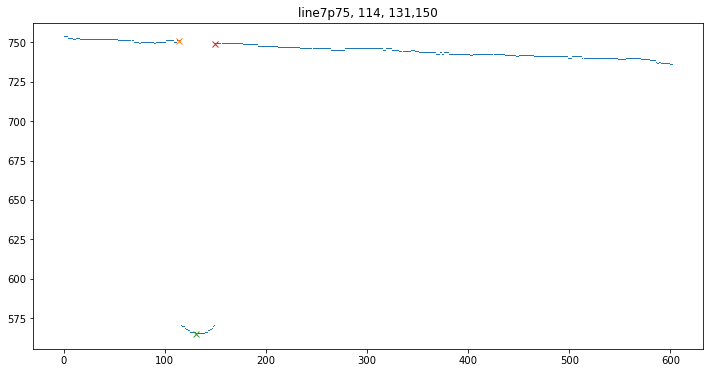

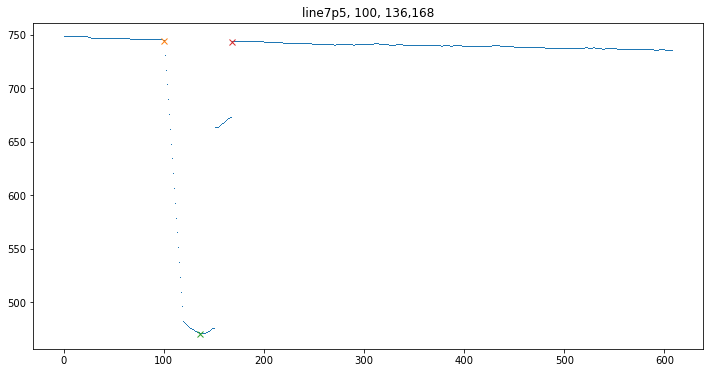

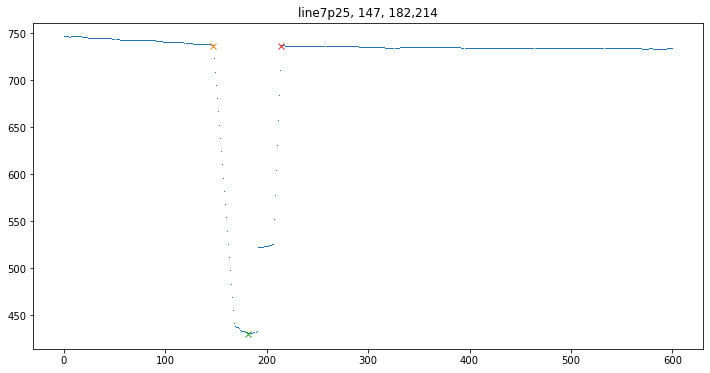

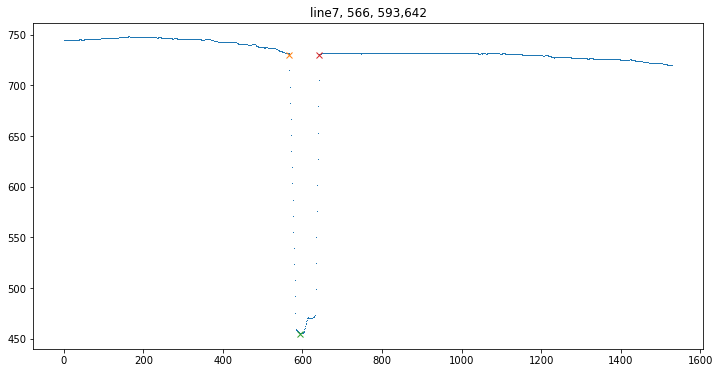

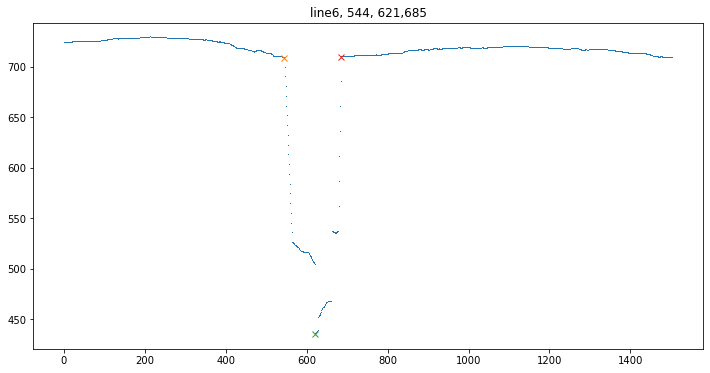

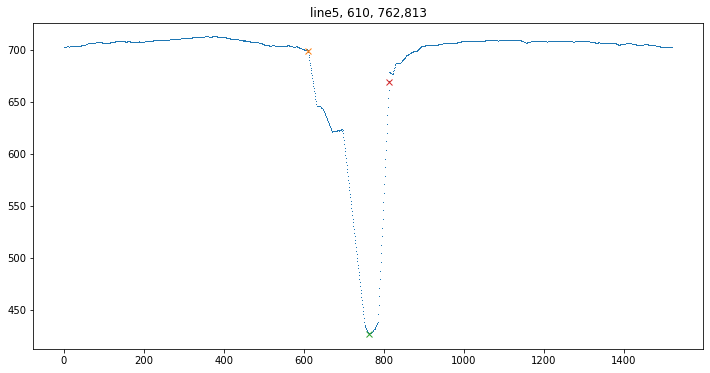

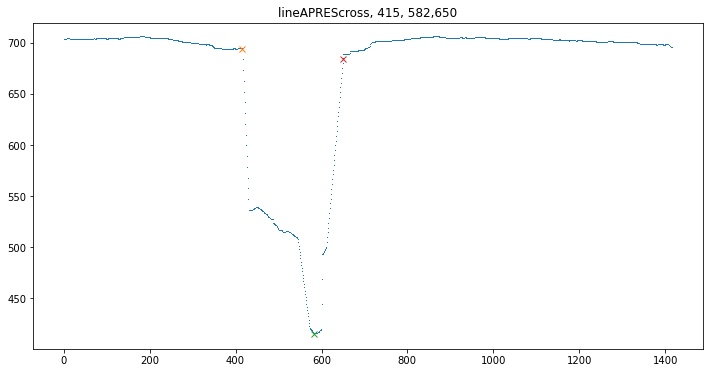

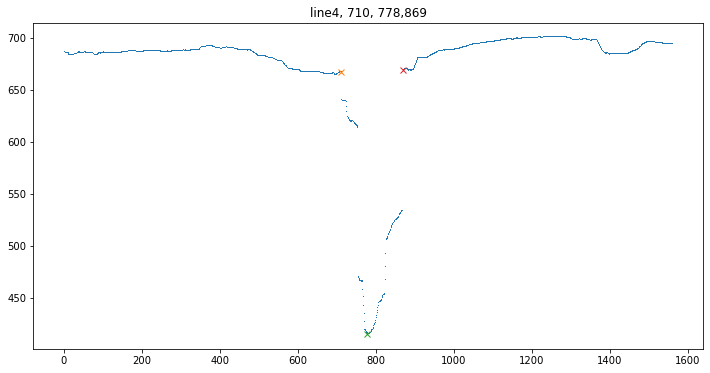

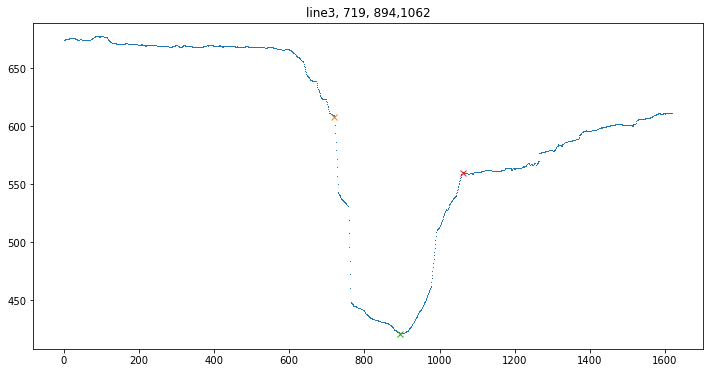

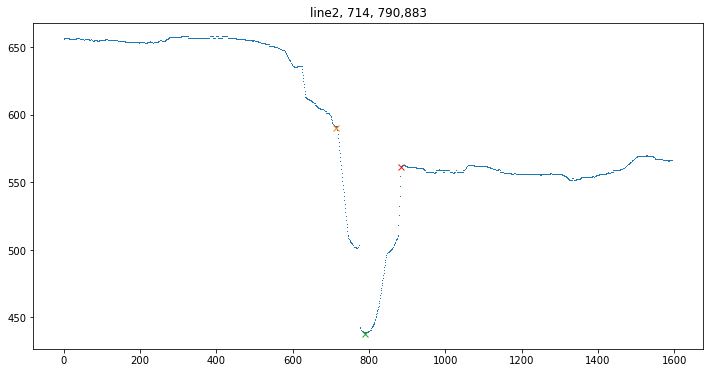

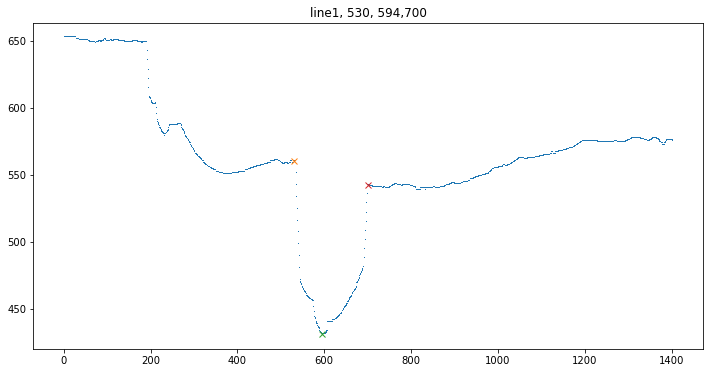

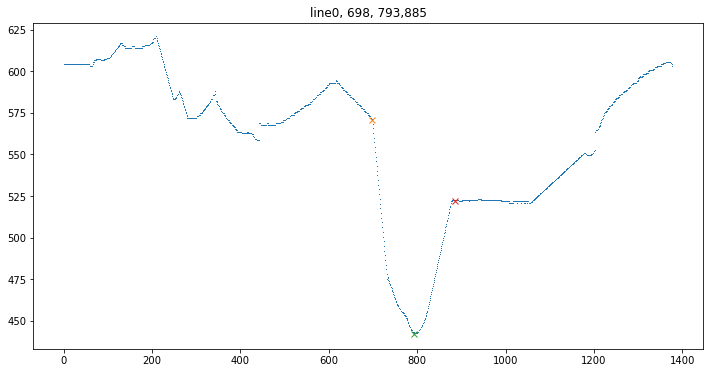

In [12]:
# double check we've picked the right bits.
for key,value in cl.items():
    plt.figure(figsize=(12,6))
    plt.plot(value.ice_thickn,',')
    plt.plot(channel_lmr[key][0],value.loc[channel_lmr[key][0]].ice_thickn,'x')
    plt.plot(channel_lmr[key][1],value.loc[channel_lmr[key][1]].ice_thickn,'x')
    plt.plot(channel_lmr[key][2],value.loc[channel_lmr[key][2]].ice_thickn,'x')
    plt.title(f"{key}, {channel_lmr[key][0]}, {channel_lmr[key][1]},{channel_lmr[key][2]}")
    plt.show()

In [13]:
cl['line6'].keys()

Index(['CDP', 'x', 'y', 'DELAY', 'line_name', 'surf', 'Unnamed_ 1', 'SEQnum',
       'camp', 'time_UTC', 'ice_thickn', 'bed', 'geometry', 'dx', 'distan_cum',
       'dice_thickn', 'dice_thickndx'],
      dtype='object')

In [14]:
max_chan_depth = {}
for key,value in cl.items():
    max_chan_depth[key] = value.loc[channel_lmr[key][0]].ice_thickn - value.loc[channel_lmr[key][1]].ice_thickn
    

In [15]:
max_chan_depth

{'line7p75': 185.83047303456215,
 'line7p5': 273.3400506116426,
 'line7p25': 306.1814907836445,
 'line7': 275.04135685277157,
 'line6': 273.3866020483278,
 'line5': 272.55837950838423,
 'lineAPREScross': 278.46231375539566,
 'line4': 252.39786507784373,
 'line3': 186.79907182433516,
 'line2': 152.2975591585261,
 'line1': 128.75327838444474,
 'line0': 128.74300749688342}

In [16]:
cl['line4'].distan_cum

0          0.000000
1          1.720465
2          5.203280
3          9.326386
4         11.311329
           ...     
1557    4670.436065
1558    4672.920014
1559    4677.030974
1560    4679.092527
1561    4682.934402
Name: distan_cum, Length: 1562, dtype: float64

In [17]:
chan_width = {}
for key,value in cl.items():
    chan_width[key] = - value.loc[channel_lmr[key][0]].distan_cum + value.loc[channel_lmr[key][2]].distan_cum

In [18]:
chan_width

{'line7p75': 109.34043364793365,
 'line7p5': 205.00647028153065,
 'line7p25': 202.28432666606716,
 'line7': 226.12779892173353,
 'line6': 423.642734832795,
 'line5': 608.2482536419318,
 'lineAPREScross': 705.2875504654685,
 'line4': 477.5636358009774,
 'line3': 1028.547857974253,
 'line2': 507.74850785629224,
 'line1': 509.92731340577325,
 'line0': 559.1422423438894}

In [ ]:
#figure chan width
key = 'line7p5'
value = cl[key].copy()
plt.figure(figsize=(12,6))
plt.plot(value.ice_thickn,',')
a = 119
b = 150
plt.plot(a,value.loc[a].ice_thickn,'x')
plt.plot(b,value.loc[b].ice_thickn,'x')
plt.show()

print(value.loc[a].distan_cum - value.loc[b].distan_cum)


# make line 7p75 zero

In [ ]:
#draw a line between left and right sides of channel
fill_gap = np.linspace(cl['line7p75'].loc[channel_lmr['line7p75'][0]].ice_thickn,
                       cl['line7p75'].loc[channel_lmr['line7p75'][2]].ice_thickn,
                       cl['line7p75'].loc[channel_lmr['line7p75'][0]:channel_lmr['line7p75'][2]].shape[0])
cl['line7p75'].loc[channel_lmr['line7p75'][0]:channel_lmr['line7p75'][2],'ice_thickn'] = fill_gap 

In [ ]:
plt.plot(cl['line7p75'].ice_thickn,'x')

# continue

In [22]:
#get just the channel part of the df
chan_dfs = {}
for key,value in cl.items():
    
    chan_dfs[key] = cl[key].loc[channel_lmr[key][0]:channel_lmr[key][2]] 
#     chan_dfs[key].reset_index(drop=True,inplace=True)


In [23]:
# add normalised_distance
for line,value in chan_dfs.items():

    #first get distance from left to centre
    left_i = channel_lmr[line][0]
    mid_i = channel_lmr[line][1]
    right_i = channel_lmr[line][2]
    # l2c = left to mid
    dist_l2m = ((chan_dfs[line].distan_cum.loc[left_i:mid_i].copy() - chan_dfs[line].distan_cum.loc[left_i])/
                (2*(chan_dfs[line].distan_cum.loc[mid_i] - chan_dfs[line].distan_cum.loc[left_i])))[:-1]
    #centre to right
    dist_m2r = ((chan_dfs[line].distan_cum.loc[mid_i:right_i].copy() - chan_dfs[line].distan_cum.loc[mid_i])/
                (2*(chan_dfs[line].distan_cum.loc[right_i] - chan_dfs[line].distan_cum.loc[mid_i]))) + 0.5    

    value['normalised_distance'] = pd.concat([dist_l2m,dist_m2r])
    
#     chan_dfs[line]['normalised_distance'] = 
    

/Users/home/whitefar/miniconda3/envs/remote_sensing/lib/python3.7/site-packages/ipykernel_launcher.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  from ipykernel import kernelapp as app


In [24]:
def interp_chan(gdf):
    """
    Input: Gdf with 'normalised_dist' as a column
    
    bin the ice thickness & coordinates in the channel
    
    Output: gdf only over the channel, all variables binned to certain cross channel intervals
    """
    
    f_x = sp.interpolate.interp1d( gdf.normalised_distance ,gdf.x  ) #corresponding bins for each point
    f_y = sp.interpolate.interp1d( gdf.normalised_distance ,gdf.y )
    f_ice_thickn = sp.interpolate.interp1d( gdf.normalised_distance ,gdf.ice_thickn)
    f_surf = sp.interpolate.interp1d( gdf.normalised_distance ,gdf.surf)
    f_bed = sp.interpolate.interp1d( gdf.normalised_distance ,gdf.bed)
                           
    cc = np.linspace(0,1,100) #cross channel 
    
    gdf_out = pd.DataFrame({})
    gdf_out['x'] = f_x(cc)
    gdf_out['y'] =  f_y(cc)
    gdf_out['ice_thickn'] = f_ice_thickn(cc)
    gdf_out['surf'] = f_surf(cc)
    gdf_out['bed'] = f_bed(cc)
    
    geometry = [Point(xy) for xy in zip(gdf_out.x,gdf_out.y)]
    gdf_out = gpd.GeoDataFrame(gdf_out,geometry=geometry,crs="EPSG:3031")
    
    return gdf_out

In [25]:
#for every cross channel line, interpolate the channel and get values every 1/100th of the way along

c_interpd = {}

for key,value in chan_dfs.items():
    c_interpd[key] = interp_chan(value)

In [26]:
#vertical slice ( a column) is over one radar line
ice_thickn = np.array([value.ice_thickn.tolist() for value in c_interpd.values()]).T
points_x = np.array([value.x for value in c_interpd.values()]).T
points_y = np.array([value.y for value in c_interpd.values()]).T
surf = np.array([value.surf.tolist() for value in c_interpd.values()]).T
bed = np.array([value.bed.tolist() for value in c_interpd.values()]).T
#[line[0] for line in points] gets one point from each for points

In [27]:
# make array of distance down chan
distance_downchan = np.zeros(points_x.shape)

for i in range(points_x.shape[0]):
    x = points_x[i,:]
    y = points_y[i,:]

    points = np.array([x, y]).T  # a (nbre_points x nbre_dim) array

    # Linear length along the line:
    distance = np.cumsum( np.sqrt(np.sum( np.diff(points, axis=0)**2, axis=1 )) )
    distance_downchan[i,:] = np.insert(distance, 0, 0) #adds a zero to the beginning

## Now do 1D spline over distance

to learn how to spline by distance https://stackoverflow.com/questions/52014197/how-to-interpolate-a-2d-curve-in-python

In [28]:
number_of_new_points = 399 # number_of_new_points to interpolate between existing points
new_length =  number_of_new_points*(points_x.shape[1]-1)+points_x.shape[1]  
ice_thickn_new = np.zeros([ice_thickn.shape[0], new_length])
points_x_new = ice_thickn_new.copy()
points_y_new = ice_thickn_new.copy()
distance_downchan_new = ice_thickn_new.copy()

for i in range(distance_downchan.shape[0]):
    
    x = points_x[i,:]
    y = points_y[i,:]
    it = ice_thickn[i,:]
    d = distance_downchan[i,:]
    
    #get tck for spline
    x_tck = sp.interpolate.splrep(d, x)
    y_tck = sp.interpolate.splrep(d, y)
    it_tck = sp.interpolate.splrep(d, it)
    
#     choose new points to interp at 
    d_new = np.linspace(distance_downchan[i,:][0],distance_downchan[i,:][-1],new_length)
    
#     interpolate values
    x_new = sp.interpolate.splev(d_new, x_tck, der=0)
    y_new = sp.interpolate.splev(d_new, y_tck, der=0)
    it_new = sp.interpolate.splev(d_new, it_tck, der=0)
    
    points_y_new[i,:] = y_new
    points_x_new[i,:] = x_new
    ice_thickn_new[i,:] = it_new
    distance_downchan_new[i,:] = d_new
    
#     plt.figure()
#     plt.plot(x_new,it_new,'1')
#     plt.plot(x,it,'x')
#     plt.grid()
#     plt.title(f'thickness {i}')
#     plt.show()
    
#     plt.figure()
#     plt.plot(x_new,y_new,'1')
#     plt.plot(x,y,'x')
#     plt.grid()
#     plt.title(f'y {i}')
#     plt.show()

In [29]:
points_x.shape[1]

12

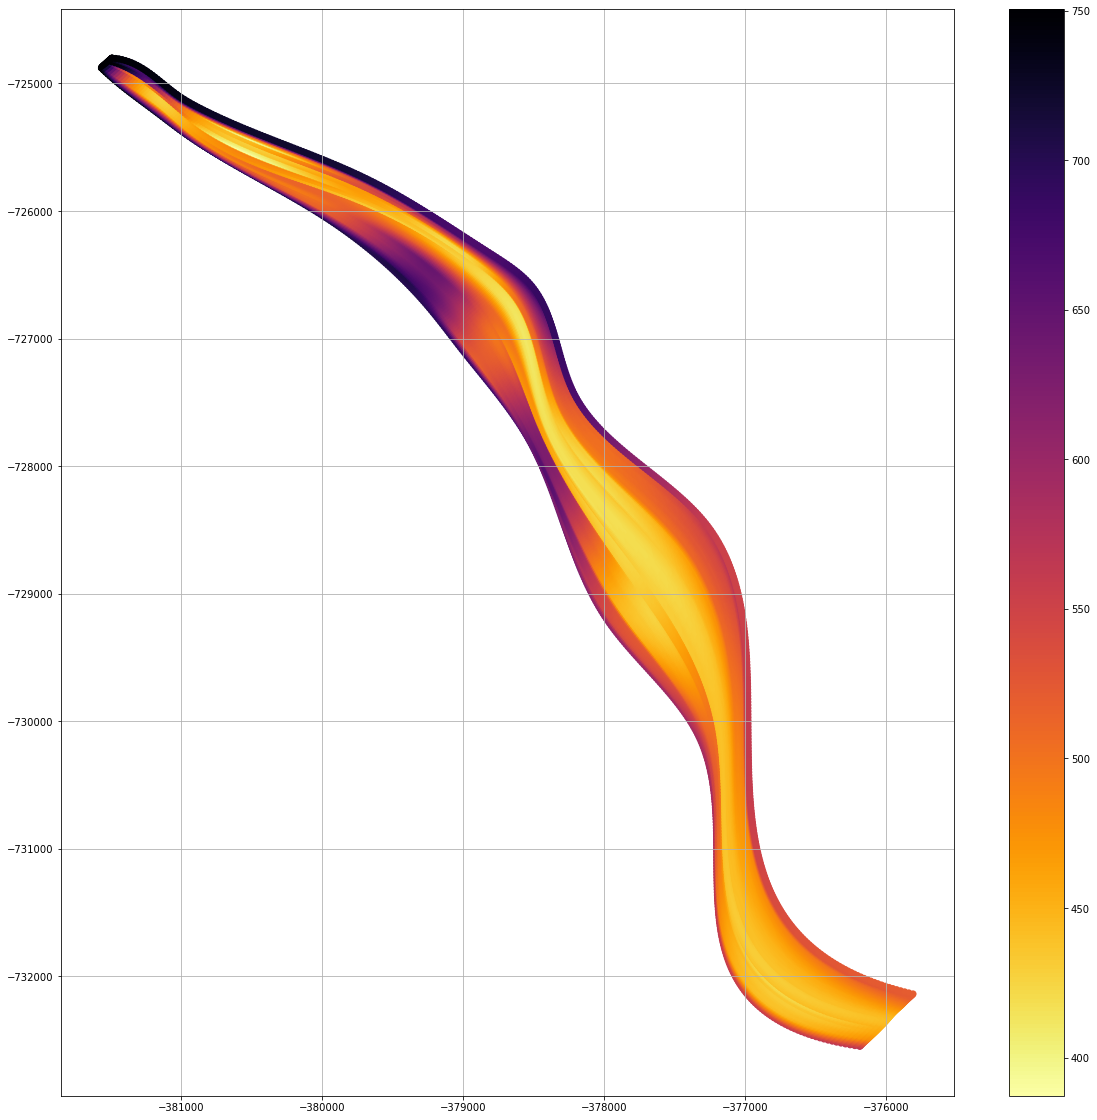

In [30]:
plt.figure(figsize=(20,20))
plt.scatter(points_x_new[:,::10],points_y_new[:,::10],c=ice_thickn_new[:,::10],cmap='inferno_r')
# plt.xlim([-382000,-381300])
# plt.ylim([-725100,-724400])

plt.colorbar()
plt.grid()

In [31]:
points_x_new.shape

(100, 4401)

### Plot cross sections

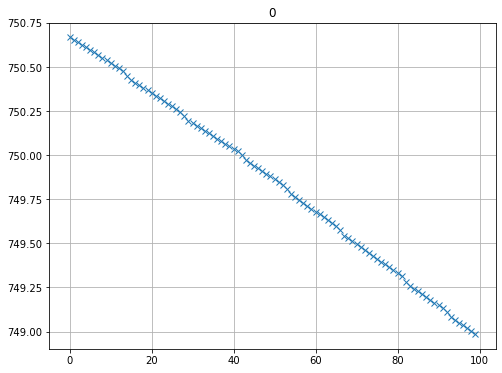

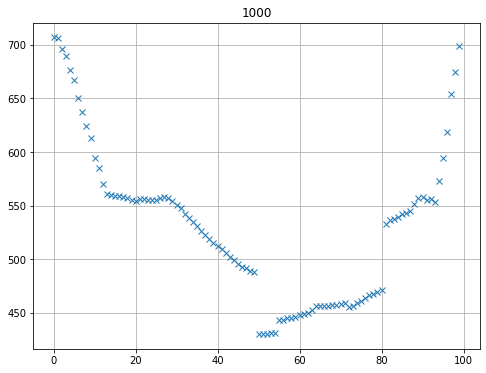

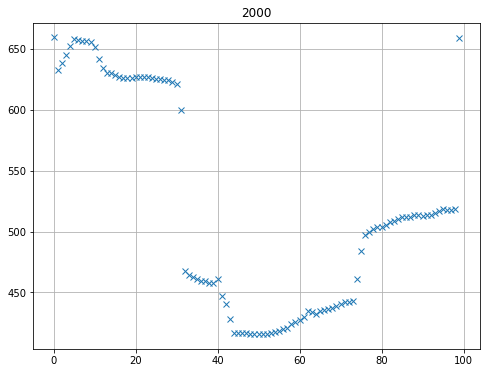

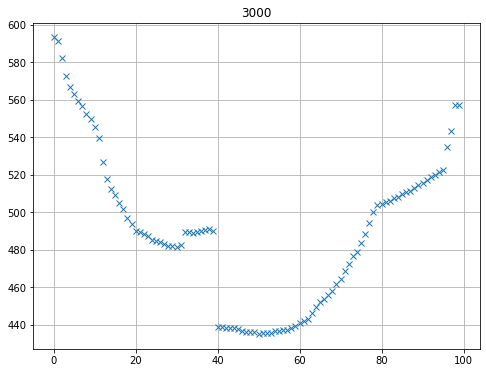

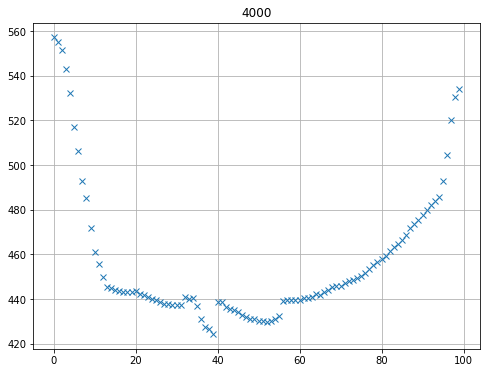

In [32]:
for i in range(ice_thickn_new.shape[1])[::1000]:
    plt.figure(figsize=(8,6))
    plt.plot(ice_thickn_new[:,i],'x')
    plt.title(i)
    plt.grid()
    plt.show()

In [33]:
# gdf = bed_gdf.query("camp == 'KIS2' & line_name != 'lineoldAPREScross' & line_name != 'lineold4'").copy()
gdf = bed_gdf[bed_gdf.camp =='KIS2'].copy()

Text(0.5, 1.0, 'interpd channel and old and new radar lines')

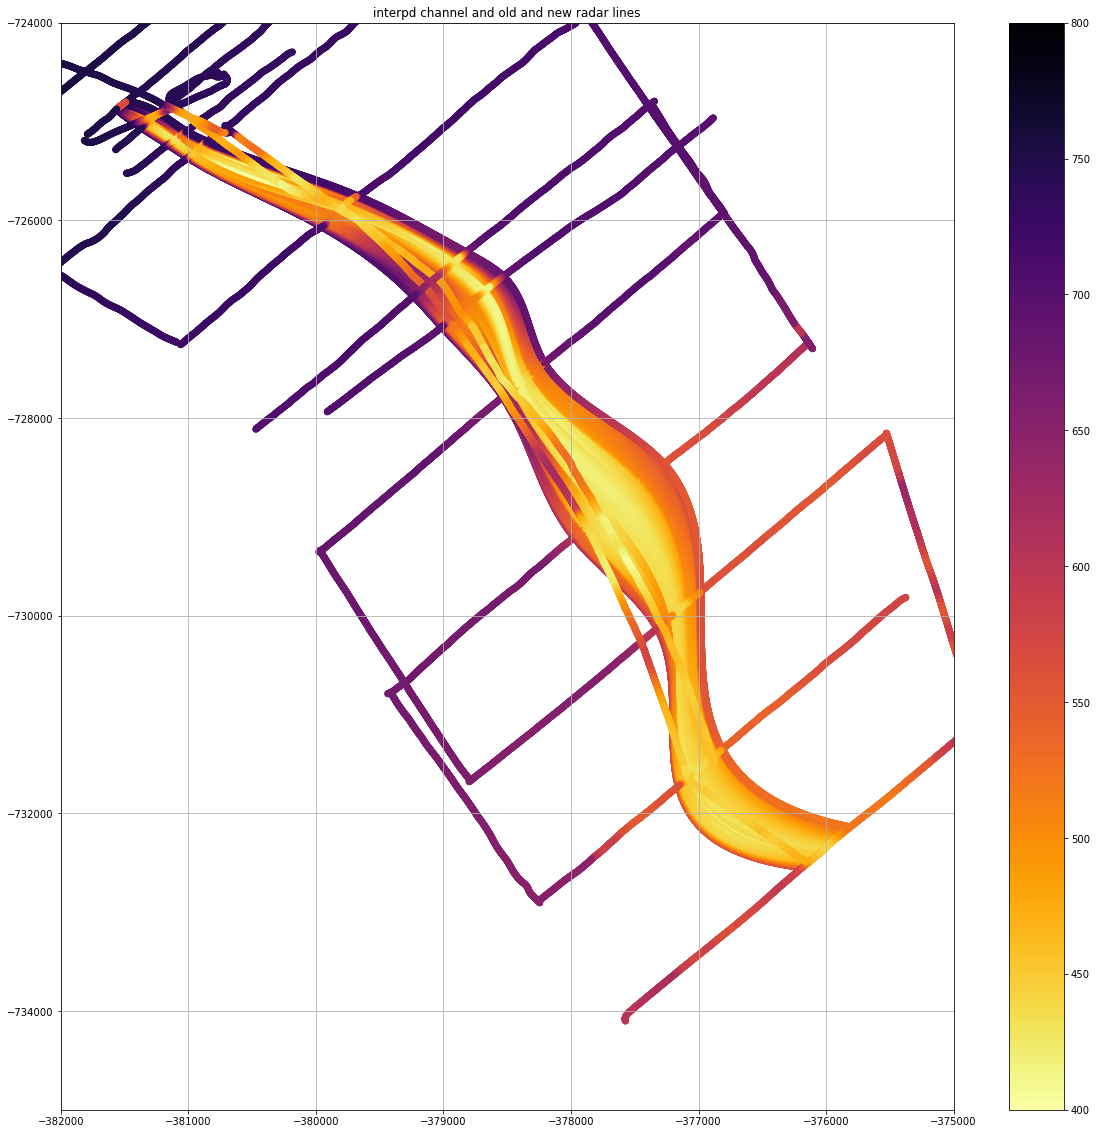

In [34]:
plt.figure(figsize=(20,20))
plt.scatter(points_x_new,points_y_new,c=ice_thickn_new,cmap='inferno_r',vmin=400, vmax=800)
plt.scatter(new_gpr .x,new_gpr .y,c=new_gpr .ice_thickn,cmap='inferno_r',vmin=400, vmax=800)
plt.xlim([-382000, -375000])
plt.ylim([-735000,-724000])
plt.colorbar()
plt.grid()
plt.title('interpd channel and old and new radar lines')

In [35]:
np.save('/Users/home/whitefar/DATA/FIELD_ANT_19/POST_FIELD/RADAR_MAP/highres_line2line_interpbydist_points_x.npy',points_x_new)
np.save('/Users/home/whitefar/DATA/FIELD_ANT_19/POST_FIELD/RADAR_MAP/highres_line2line_interpbydist_points_y.npy',points_y_new)
np.save('/Users/home/whitefar/DATA/FIELD_ANT_19/POST_FIELD/RADAR_MAP/highres_line2line_interpbydist_ice_thickn.npy',ice_thickn_new)

In [36]:
extent = np.array([points_x_new.min(),points_x_new.max(),points_y_new.min(),points_y_new.max()])
extent

array([-381564.3, -375809.9, -732549.6, -724800.5])

In [37]:
np.save('/Users/home/whitefar/DATA/FIELD_ANT_19/POST_FIELD/RADAR_MAP/highres_line2line_interpbydist_extent.npy',extent)

In [38]:
# take care running this as the variables ice_thickn points_x etc are used a few times for different interpolations
np.save('/Users/home/whitefar/DATA/FIELD_ANT_19/POST_FIELD/RADAR_MAP/highres_ice_thickn_channel.npy',ice_thickn)
np.save('/Users/home/whitefar/DATA/FIELD_ANT_19/POST_FIELD/RADAR_MAP/highres_points_x_channel.npy',points_x)
np.save('/Users/home/whitefar/DATA/FIELD_ANT_19/POST_FIELD/RADAR_MAP/highres_points_y_channel.npy',points_y ) 
#bed and surf are duds

In [39]:
1+1

2